In [1]:
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

In [5]:
# initialize parameters and variables
dt = 0.001
radius = 5
nt=20000
K = 2

# angular velocity inputs
Nr = 100
beta = np.random.randn(int(Nr/2),1)*10
beta = np.concatenate([beta,-beta]) 

np.random.seed(1111)
# ang_vel = np.ones(nt)*0.005
ang_vel=ndi.gaussian_filter1d(np.concatenate([[np.random.randn()]*1000 for _ in range(int((nt+1)/1000))])*0.005,500)
kernel = np.exp(beta @ ang_vel.reshape(1,-1))
s = np.random.poisson(kernel) 
alpha = (1 + beta.T@beta*dt)[0,0]

N = 8
lam = 5

D = np.array([[np.sin(2*np.pi/N*i),np.cos(2*np.pi/N*i)] for i in range(N)])/2
T = np.diag(D @ D.T)/2

# interactions
O_f = - D @ D.T
O_s = lam * D @ D.T

# # slow nonlinear interactions
def DU_xy(s_t, r_t):
    z = D.T @ r_t # readout
    rot_z = np.array([z[1], -z[0]]) # rotated readout
    # observation gain
    obs_gain = (beta.T @ (s_t - 1.0)).item() / alpha
    observation = -obs_gain * rot_z
    # soft ring attractor
    ring = -4.0 * z * (z @ z - radius**2)
    return observation + ring

# reset nonlinear interactions
gamma = 1
def DU_reset(sigma_res, r_new):
    # 1- x / r^2, xy \ (r^2 + x)
    x,y = r_new
    return gamma*2*np.array([(x-radius)*np.exp(-gamma*(x-radius)**2 - gamma*y**2) - sigma_res*(x-radius), 
                              y *       np.exp(-gamma*(x-radius)**2 - gamma*y**2) - sigma_res*y
                     ])


In [13]:
rng = np.random.default_rng(0)

r_real = np.zeros((K, nt))
rs = np.zeros((K, nt))

ang = 0.0
r0 = np.array([radius * np.cos(ang), radius * np.sin(ang)])
r_real[:, 0] = r_real[:, 1] = r_real[:, 2] = r0

V = np.zeros((N, nt))
V[:, 0] = 0.95 * T

sigma = np.zeros((N, nt))
r = np.zeros((N, nt))
r[:, 0] = r[:, 1] = r[:, 2] = np.linalg.pinv(D.T) @ r_real[:, 0]

for t in range(2, nt - 1):
    ang += ang_vel[t - 1]
    r_real[:, t] = np.array([radius * np.cos(ang), radius * np.sin(ang)])

    x, y = r_real[:, t]
    sigma_reset_rate = np.exp(-gamma * (x - radius)**2 - gamma * y**2)
    sigma_reset = float(rng.poisson(sigma_reset_rate))

    V[:, t + 1] = V[:, t] + dt * (
        -lam * V[:, t]
        + D @ DU_xy(s[:, t], r[:, t])
        + O_s @ r[:, t]
        + O_f @ sigma[:, t]
        + 20 * D @ DU_reset(sigma_reset, D.T @ r[:, t])
    ) + D @ (rng.standard_normal(K) * np.sqrt(2 * dt))

    above = np.where(V[:, t + 1] > T)[0]
    if len(above):
        sigma[above[rng.integers(len(above))], t + 1] = 1 / dt

    r[:, t + 1] = r[:, t] + dt * (sigma[:, t + 1] - lam * r[:, t])

x_y_est = D.T @ r
xs = x_y_est[0, :]
ys = x_y_est[1, :]


## Panel B

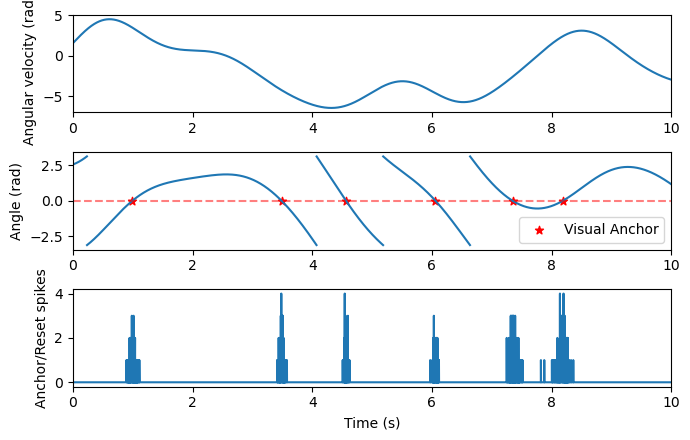

In [14]:
# plot 4 subplots with: angular velocity, input spikes, true angle with line at zero, visual reset spikes
# plot only from 4 to 14 seconds
beg,end = 4000,14000

t = np.arange(nt)[beg:end]*dt - 4
plt.figure(figsize=(7,4.5))
plt.subplot(3,1,1)
plt.plot(t, ang_vel[beg:end]/dt)
plt.ylabel('Angular velocity (rad/s)')
plt.xlim(0,(end-beg)*dt)
plt.subplot(3,1,2)
# avoid plotting vertica lines going from pi to -pi or -pi to pi
ang = np.mod(np.cumsum(ang_vel) + np.pi, 2*np.pi) - np.pi
# set to nan the transitions from pi to -pi or -pi to pi
transitions = np.where(np.abs(np.diff(ang)) > np.pi)[0] + 1
ang[transitions] = np.nan
plt.plot(t, ang[beg:end])
plt.ylabel('Angle (rad)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
# plot stars at the crossing of zero
zero_crossings = np.where((np.diff(np.sign(ang[beg:end]))!=0)*(np.abs(np.diff(ang[beg:end]))<0.1))[0]
plt.scatter(t[zero_crossings], ang[beg:end][zero_crossings], color='red', marker='*',label='Visual Anchor')
plt.legend()
plt.xlim(0,(end-beg)*dt)
plt.subplot(3,1,3)
ang = np.cumsum(ang_vel)[beg:end]
x,y = np.array([radius*np.cos(ang), radius*np.sin(ang)])
sigma_reset = np.random.poisson(np.exp(-gamma*(x - radius)**2 - gamma*y**2))
plt.xlim(0,(end-beg)*dt)
plt.plot(t, sigma_reset)
plt.xlabel('Time (s)')
plt.ylabel('Anchor/Reset spikes')
plt.tight_layout()
plt.savefig('visual_reset_inputs.pdf',dpi=300)
plt.show()

## Panel C

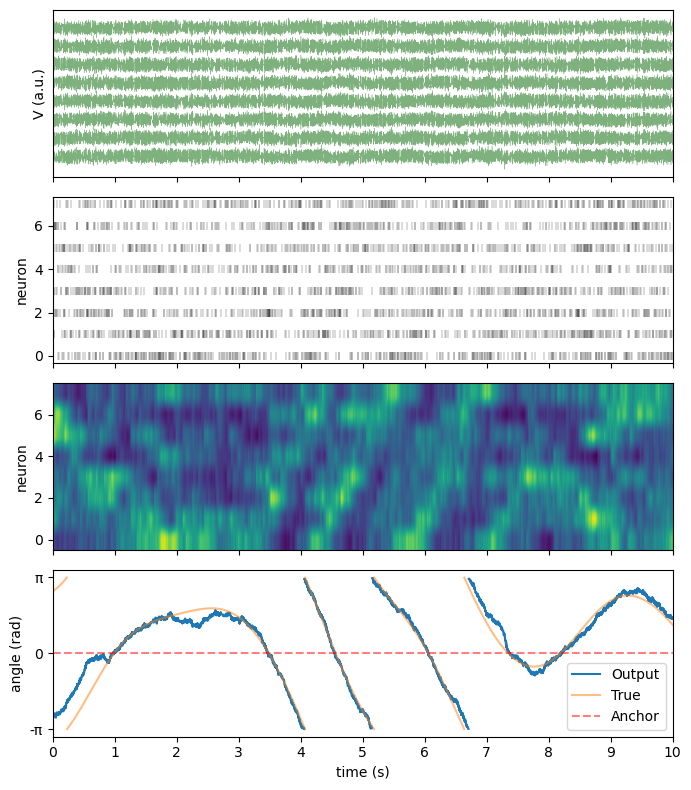

In [15]:
plt.figure(figsize=(7,8))

plt.subplot(411)

# plot voltave traces, one on each line, from beg to end
for iv,v in enumerate(V):
    plt.plot(v[beg:end] + iv*0.42,color='darkgreen',alpha=0.5,lw=0.3)
plt.xticks(np.arange(0,end-beg+1000,1000),[])
plt.yticks([])
plt.xlim(0,end-beg)
plt.ylabel('V (a.u.)')

# plot sigma as in putting a small dot wherewer a spike occurs
plt.subplot(412)
x,y = np.where(sigma[:,beg:end])
plt.scatter(y,x,marker='|',rasterized=True,lw=0.2,c='k')
plt.xticks(np.arange(0,end-beg+1000,1000),[])
plt.xlim(0,end-beg)
plt.ylabel('neuron')
plt.yticks(np.arange(0,N,2))


plt.subplot(413)
plt.imshow(r[:,beg:end],aspect='auto',origin='lower')
plt.xticks(np.arange(0,end-beg+1000,1000),[])
plt.ylabel('neuron')
plt.xlim(0,end-beg)
# plt.colorbar(label='Firing rate',shrink=0.7)
plt.yticks(np.arange(0,N,2))


plt.subplot(4,1,4)
# remove transitions from -pi to pi and pi to -pi
ang_est = np.mod(np.arctan2(ys, xs) + np.pi, 2*np.pi) - np.pi
transitions = np.where(np.abs(np.diff(ang_est)) > np.pi)[0] + 1
ang_est[transitions] = np.nan

plt.plot(ang_est[4000:14000],label='Output')
ang = np.mod(np.cumsum(ang_vel) + np.pi, 2*np.pi) - np.pi
# set to nan the transitions from pi to -pi or -pi to pi
transitions = np.where(np.abs(np.diff(ang)) > np.pi)[0] + 1
ang[transitions] = np.nan
plt.plot(ang[4000:14000],label='True',alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5,label='Anchor')
plt.xlabel('time (s)')
plt.ylabel('angle (rad)')
plt.tight_layout()
plt.xticks(np.arange(0,end-beg+1000,1000),np.arange(11))
plt.xlim(0,end-beg)
plt.yticks([-np.pi, 0, np.pi], ['-π', '0', 'π'])
plt.legend()
plt.savefig('visual_reset.pdf',dpi=300)
plt.show()